
<h1 align="center"> Lab 9: Machine learning for music </h1>

##### Goals:
- Create digital sound with Python
- Introduction to signal processing (Fourier transform)
- Use machine learning for classification on music data
- Discover deep learning with pytorch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
music_path = "drive/MyDrive/Data/resampled-audio/genres"
!ls drive/MyDrive/Data/resampled-audio/genres

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock


## Part 1:  basics of digital sound processing

Most signals in the real world are presented in analog format (electromagnetic / acoustic waves). To process them in a computer, we need a digital converter. An analog signal corresponding to playing the note `A` looks like:

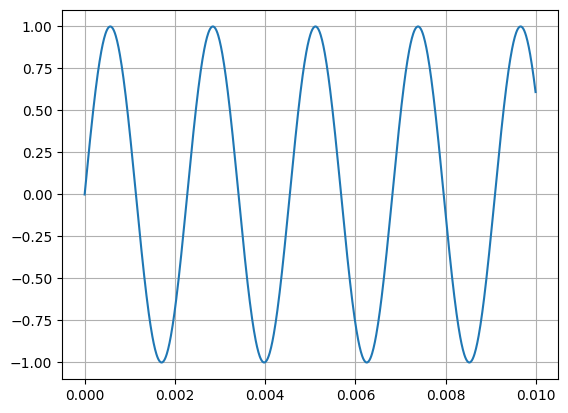

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

frequency = 440
w = 2 * np.pi * frequency
time_points = np.linspace(0., 1., 100000)
sine_wave = np.sin(w * time_points)

plt.figure()
plt.plot(time_points[:1000], sine_wave[:1000])
plt.grid()
plt.show()

A digital converter samples from this wave a certain number of points decided by the `sampling_rate` parameter. A high sampling rate is required for a good conversion of audio signals but naturally leads to more data storage requirements. For most audio systems, a sampling rate of 44100 is enough. In the example below, we use a lower sampling rate for illustrative purposes.

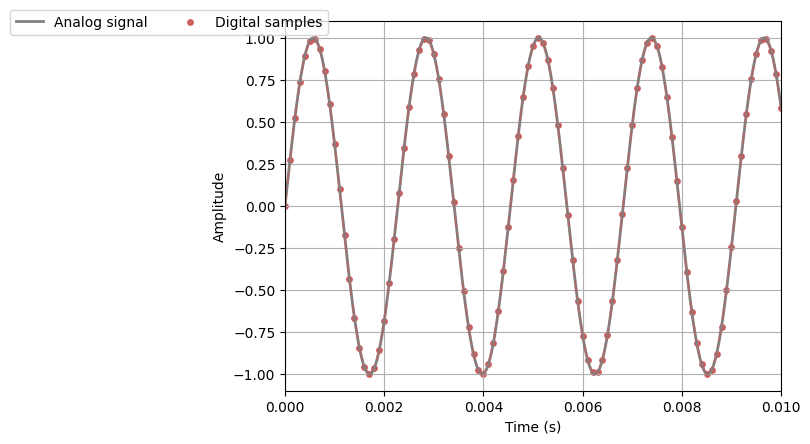

In [ ]:
def plot_sampling(frequency, sampling_rate, duration=1):
    N_full = int(duration * 100000)
    time_points_full = np.linspace(0., 1., N_full)

    N = int(duration * sampling_rate)
    time_points = np.linspace(0., 1., N)

    w = 2 * np.pi * frequency

    f, ax = plt.subplots(1, 1)
    ax.plot(time_points_full, np.sin(w * time_points_full), lw=2, color="gray", label="Analog signal")
    ax.scatter(time_points, np.sin(w * time_points), s=15, color="indianred", label="Digital samples")
    ax.plot(time_points, np.sin(w * time_points), color="indianred", ls="-.", alpha=0.5)

    ax.set_xlim([0., 0.01])
    plt.legend(ncol=2, bbox_to_anchor=[0.1, 1.05])
    plt.grid()
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

plot_sampling(frequency, 10000)

### Question 1
Using the function `plot_sampling` defined above, investigate the effect of `sampling_rate`. Select a fixed frequency of 500 and decrease the sampling rate from 10000 to 200 progressively. What do you conclude ?
Can you guess where the choice of 44100 Hz might come from ?

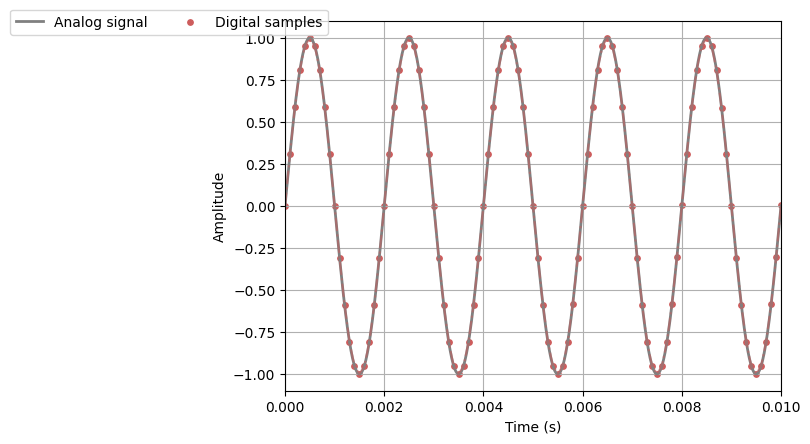

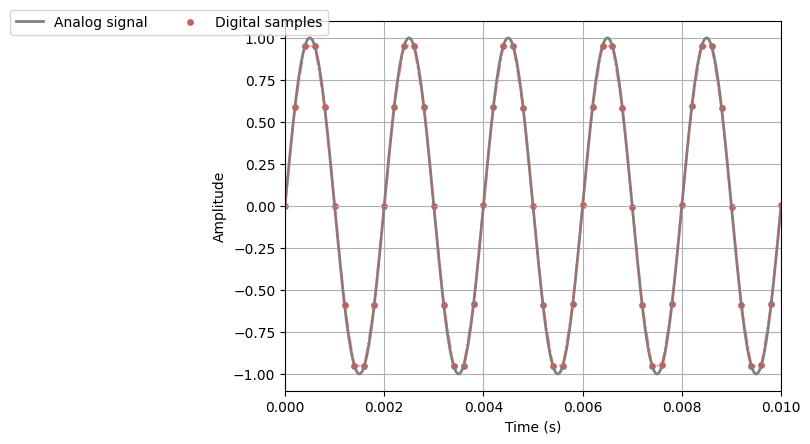

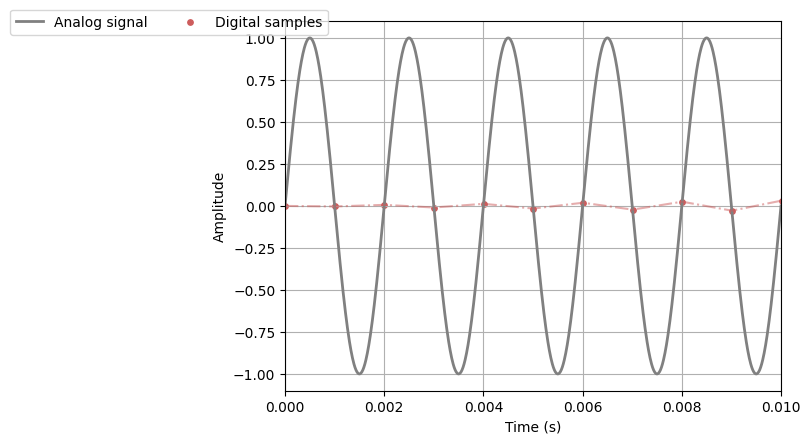

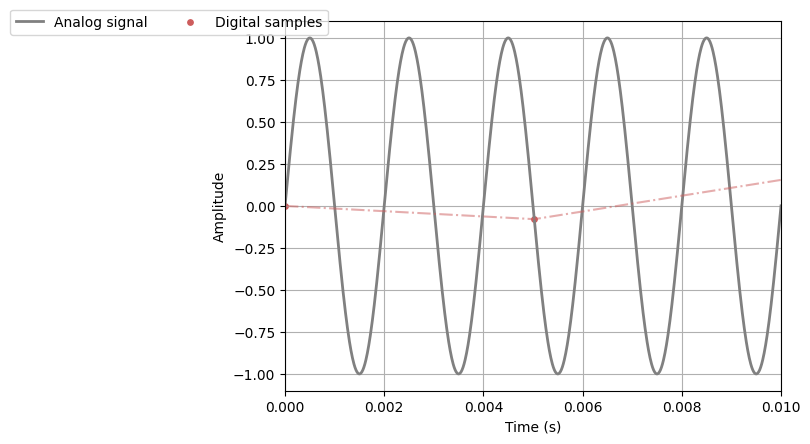

In [ ]:
for rate in [10000, 5000, 1000, 200]:
    plot_sampling(500, rate)

We wrap the code above in a nice function that makes a single tone sound wave.

In [ ]:
def make_mono_freq(frequency, duration=3, sampling_rate=44100, amplitude=16000):
    """Creates a single-frequency sound wave with duration in seconds"""
    N = int(sampling_rate * duration)
    w = 2 * np.pi * frequency
    time_points = np.arange(N) / sampling_rate
    sine_wave = amplitude * np.sin(w * time_points)
    return sine_wave

In [ ]:
from IPython.display import Audio
frequency = 1000
sampling_rate = 44100
duration = 2
sound = make_mono_freq(frequency, duration=duration, sampling_rate=sampling_rate)
print("Shape of sound data:", sound.shape)
Audio(data=sound, rate=44100)

Shape of sound data: (88200,)


Given the signal S, the discrete Fourier transform computes an "importance score" or weight of each frequency in the signal. Using the sound wave above, the Fourier transform should return zero for all frequencies except 200 since it's the only present in our signal. Our signal has real values (no complex values) we use the _Real Fast Fourier Transform (rfft)_. RFFT outputs symetric (+ and - freq), we take their absolute value using `np.abs`:

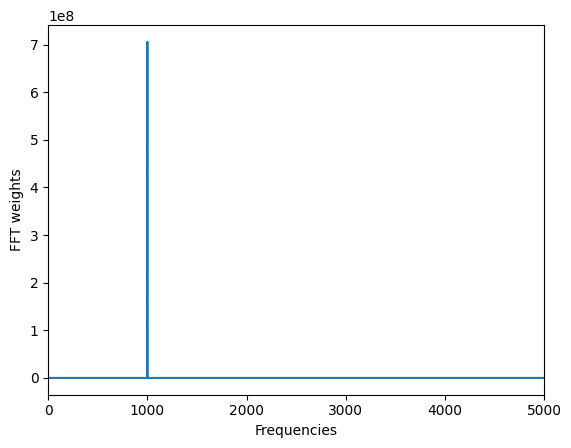

In [ ]:
from scipy.fft import rfft, rfftfreq

all_frequencies = rfftfreq(sampling_rate * duration, 1 / sampling_rate)
fft_data = rfft(sound)
fft_weights = np.abs(fft_data)
plt.plot(all_frequencies, fft_weights)
plt.ylabel("FFT weights")
plt.xlabel("Frequencies")
plt.xlim([0, 5000])
plt.show()

Extract the most interesting frequencies by truncating the weights above a small threshold:

In [ ]:
important_freq_indx = np.where(fft_weights > 0.01)
important_freq = all_frequencies[important_freq_indx]
important_freq

array([1000.])

We recovered the frequency we used to construct our signal.



### Question 1
Read and understand what does the function below then use it to create an up-beat melody with 10 frequencies.

In [ ]:

def make_multi_freq(frequencies, duration=1):
    duration_ = duration / len(frequencies)
    waves = [make_mono_freq(f, duration_) for f in frequencies]
    waves = np.concatenate(waves)
    return waves


In [ ]:
sample_freqs = [10,30, 60, 100, 130, 160, 190, 220, 260, 310]
sound = make_multi_freq(sample_freqs)
Audio(data=sound, rate=44100)

### Question 2
Contaminate this sound with a noisy high pitch tone. Use a frequency of 5000 for example and 1% of the amplitude of the clean signal. Display the wave of this signal and listen to it. Play with its amplitude to control how noisy the sum of boths signals gets.

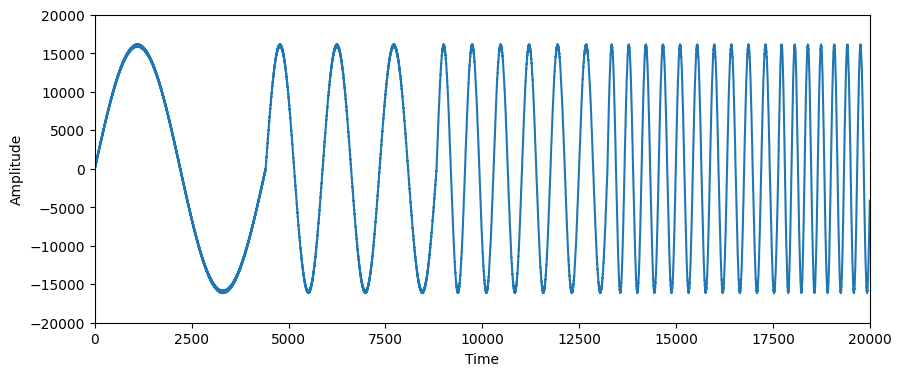

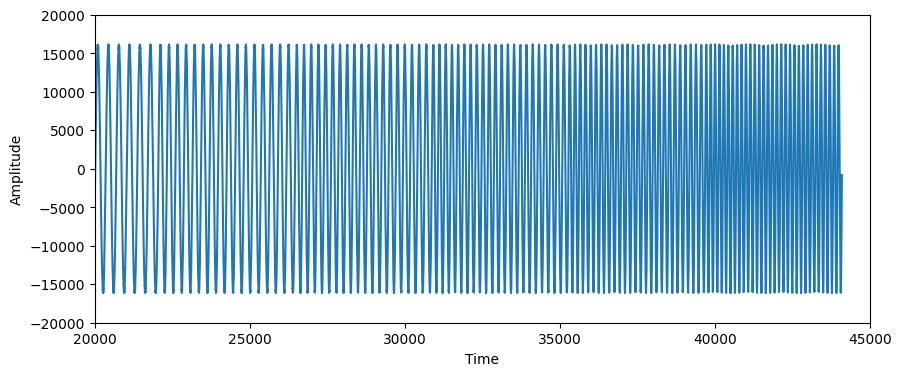

In [ ]:
amp_var = 16000 #change this for more/less high pitch
noisy_pitch = make_mono_freq(5000, duration=1, sampling_rate=44100, amplitude= .01 * amp_var)
contamination = sound + noisy_pitch

plt.figure(figsize=(10, 4))
plt.plot(contamination)
plt.ylim([-20000, 20000])
plt.xlim([0,20_000])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(contamination)
plt.ylim([-20000, 20000])
plt.xlim([20_000,45_000])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

Audio(data=contamination, rate=44100)

### Question 3
Apply the fast fourier transform on the obtained signal. In the same scipy package you will find the _Inverse real fast Fourier transform_ `irfft` which does the inverse transformation (frequency domain -> time domain). Using `irfft`, perform a denoising operation to recover the clean uncontaminated signal from the noisy one.

In [ ]:
from scipy.fft import irfft
cf = rfft(contamination)
fft_weights = np.abs(cf)

cf[cf < .01 * 16000] = 0
uncontaminated_signal = irfft(cf)
Audio(uncontaminated_signal, rate=44100)

### Question 4
While the FFT spectrum of most signals summarizes the data in a very compact manner and provides valuable information, it loses the temporal information of the signal. To keep both, we can run `FFT` over small a small temporal window that we move progressively thus "scanning" the audio signal. This is called _Short term Fourier transform_. Visualize the spectrogram for the sound, contaminated and denoised signals.

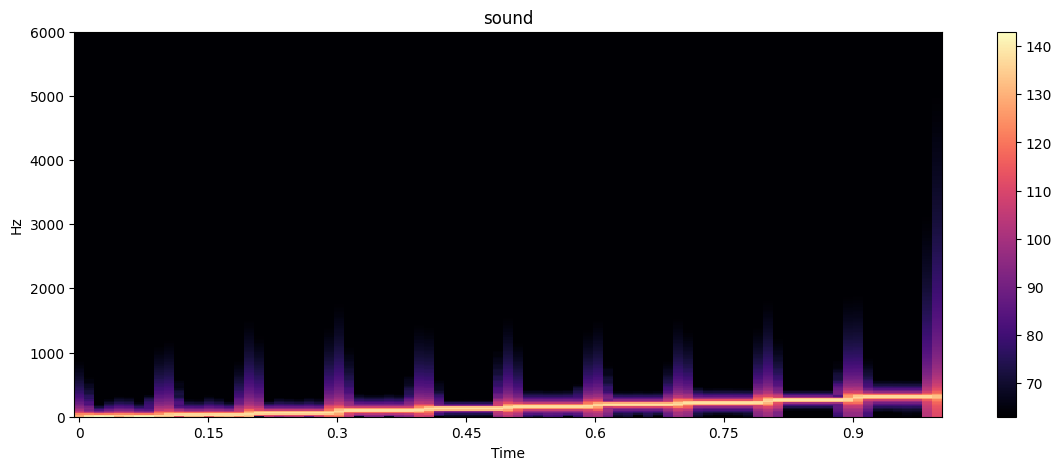

In [ ]:
import librosa
import librosa.display
X = librosa.stft(sound)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=44100, x_axis='time', y_axis='hz')
plt.ylim([0, 6000])
plt.title('sound')
plt.colorbar()

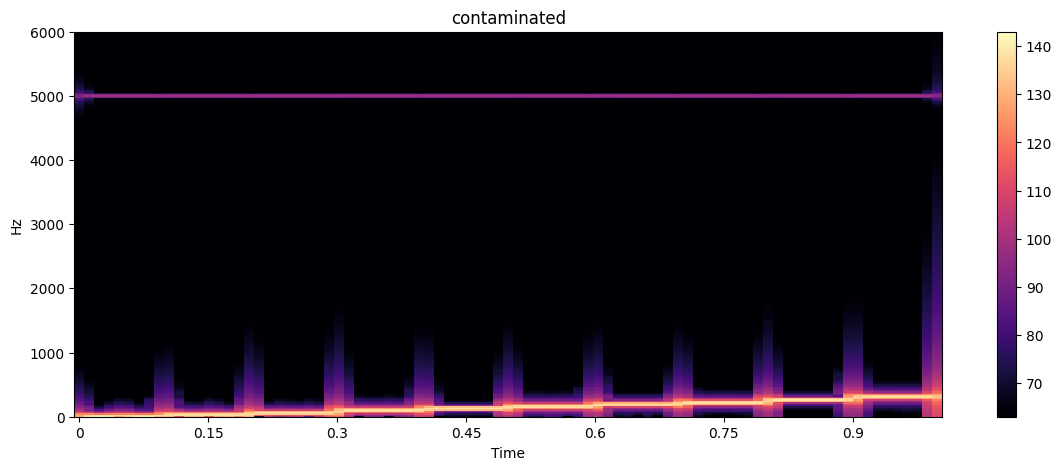

In [ ]:
X = librosa.stft(contamination)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=44100, x_axis='time', y_axis='hz')
plt.ylim([0, 6000])
plt.title('contaminated')
plt.colorbar()

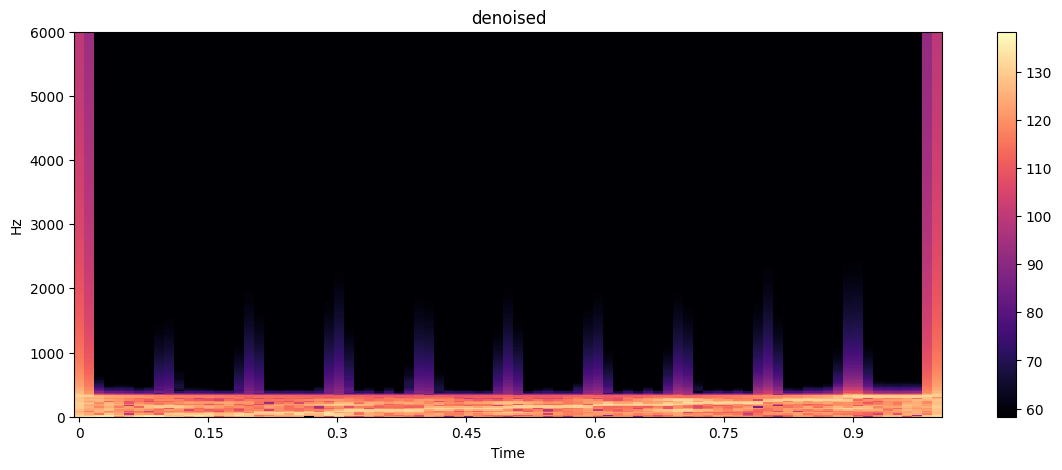

In [ ]:
X = librosa.stft(uncontaminated_signal)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=44100, x_axis='time', y_axis='hz')
plt.ylim([0, 6000])
plt.title('denoised')
plt.colorbar()

The spectrogram data can be saved as an image:

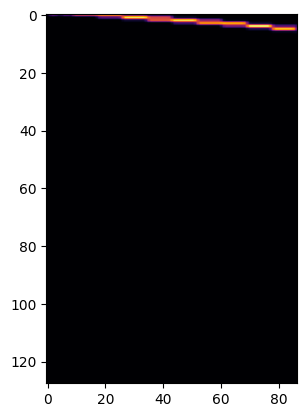

In [ ]:
cmap = plt.get_cmap('inferno')
melspect = librosa.feature.melspectrogram(y=sound, sr=22050)
plt.imshow(melspect, cmap=cmap)

# Part 2: music genre classification
The purpose of the second part of this lab is to perform music genre classification using the spectrogram of the audio signals. We create a dataset of spectrogram images from the audio files. To save time, I generated all the spectrograms beforehand and saved them as numpy .npy files. The following cell reads them:


In [ ]:
import pathlib, os
X = []
y = []
genres = ["classical", "jazz", "rock", "reggae", "blues", "metal", "pop", "disco", "hiphop", "country"]
for label, genre in enumerate(genres):
    for filename in os.listdir(f'{music_path}/{genre}/'):
        if filename.split('.')[-1] == 'npy':
            melspect = np.load(f'{music_path}/{genre}/{filename}')
            X.append(melspect)
            y.append(label)
        if filename.split('.')[-1] == 'au':
          pass
          # this is an audio file
          # it can be read using:
          # sound, sr = librosa.load(f"{music_path}/{genre}/{filename}", mono=True)



X = np.array(X)
y = np.array(y)

X /= X.max()

In [ ]:
print(X.shape, X.min(), X.max(), np.unique(y))

(1000, 128, 44) 0.0 1.0 [0 1 2 3 4 5 6 7 8 9]


In [ ]:
X_flat = X.reshape(len(X), -1)

### Question 5
To have an idea -- and satisfy your curiosity -- start by loading an audio file of each genre and listen to it. Use the function `librosa.load`. See how its used in the commented portion above.

Then display the average spectrogram of each genre.

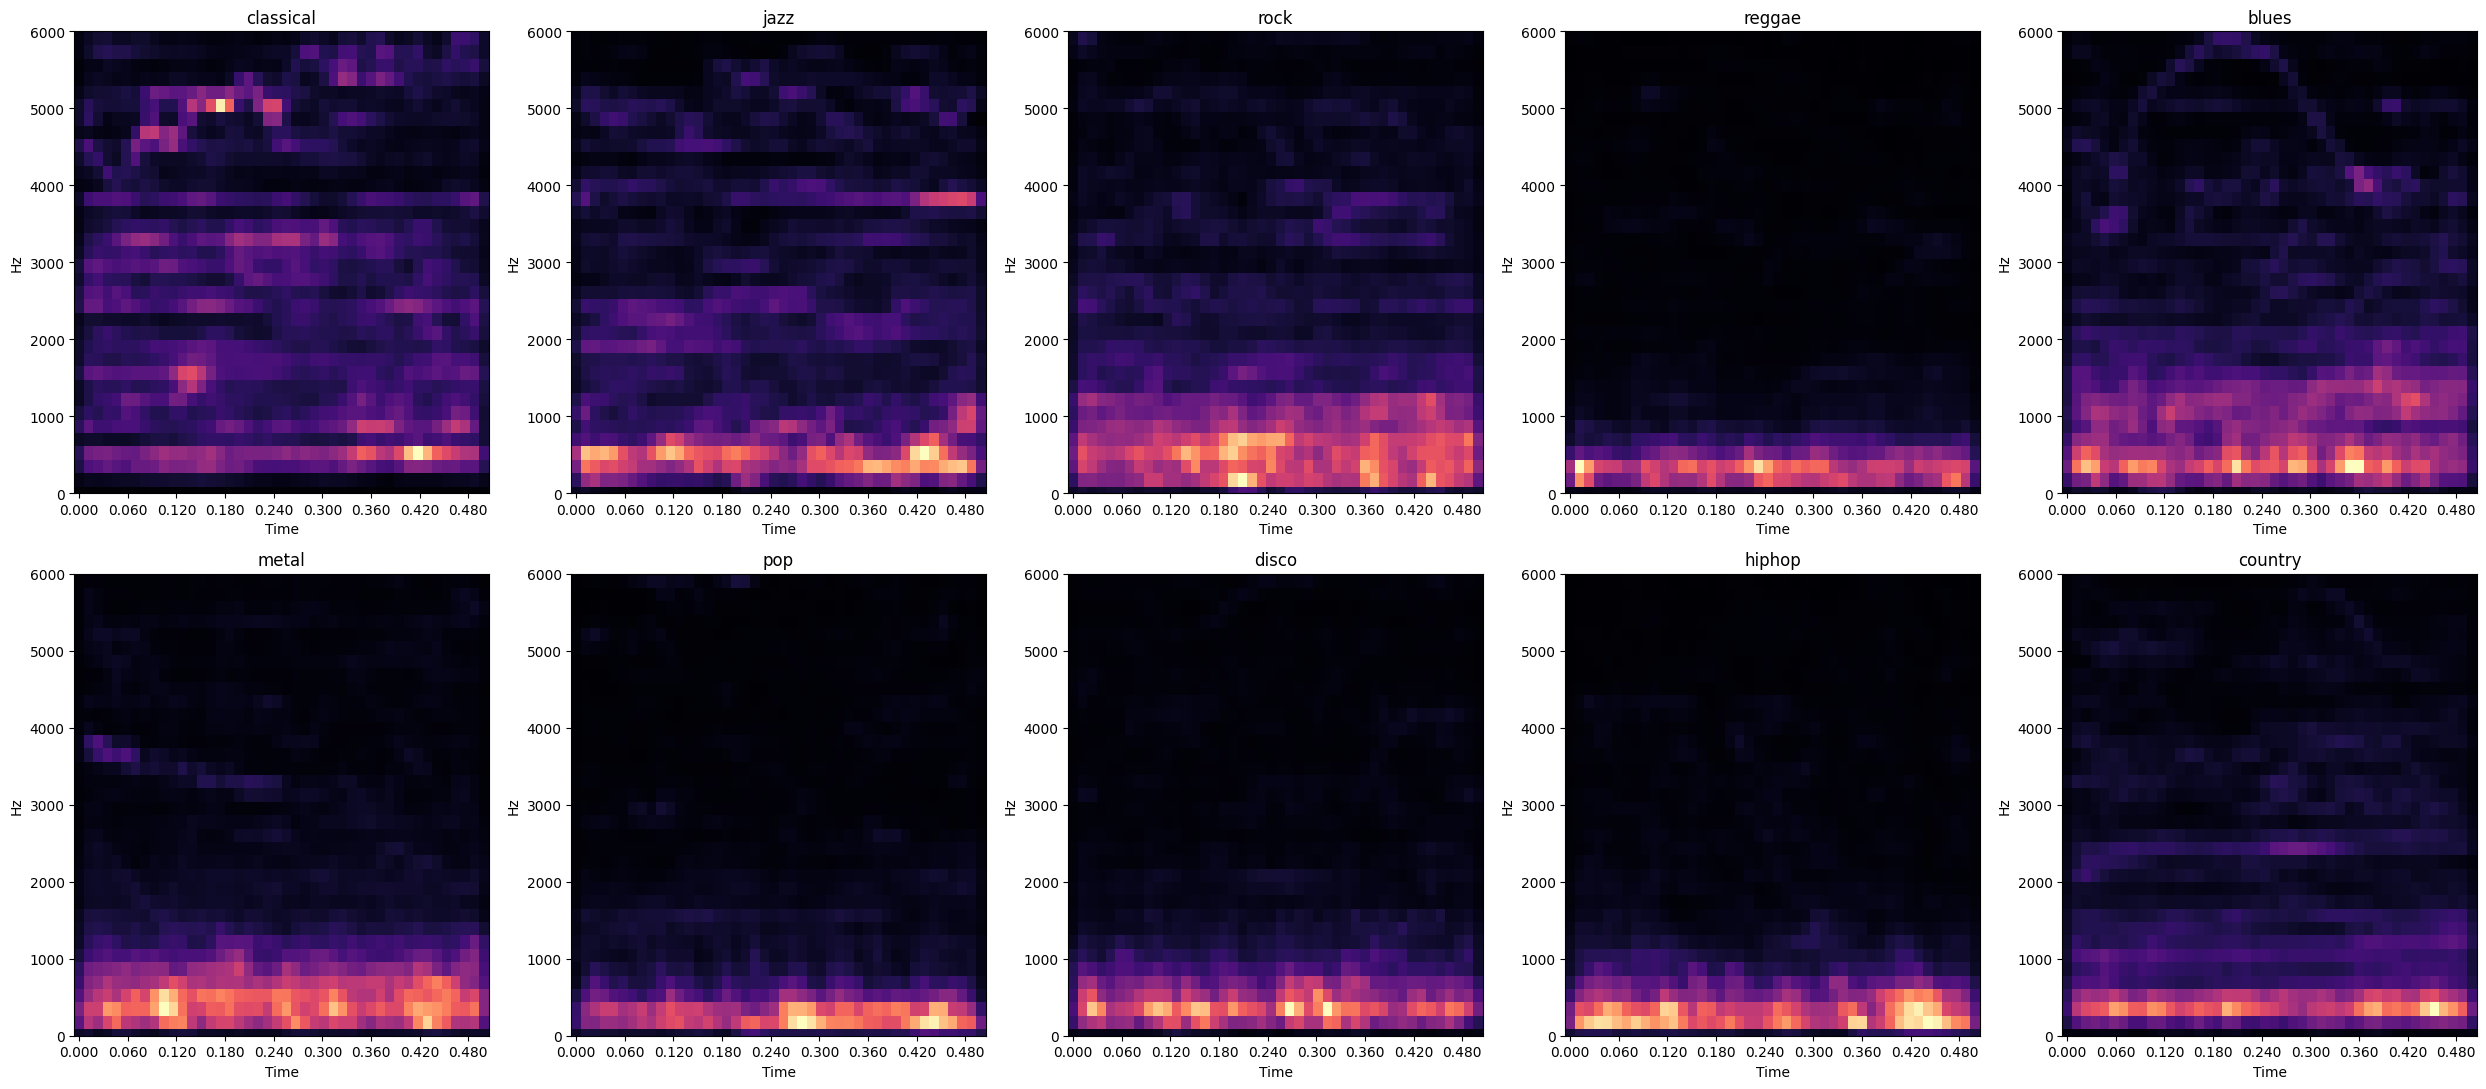

In [ ]:
for genre in genres:
    filename = os.listdir(f'{music_path}/{genre}/')[0]
    if filename.split('.')[-1] == 'au':
        sound, sr = librosa.load(f"{music_path}/{genre}/{filename}", mono=True)

plt.figure(figsize=(25, 11))
for label, genre in enumerate(genres):
    genre_spec = X[y == label]
    average_spec = np.mean(genre_spec, axis=0)
    plt.subplot(2, 5, label +1)
    librosa.display.specshow(average_spec,sr=44100, y_axis='hz', x_axis='time')
    plt.ylim([0, 6000])
    plt.title(genre)
plt.tight_layout()
plt.show()


### Question 6
Perform a PCA(2) on the the data and visualize the samples with their color-coded labels. What do you observe ?

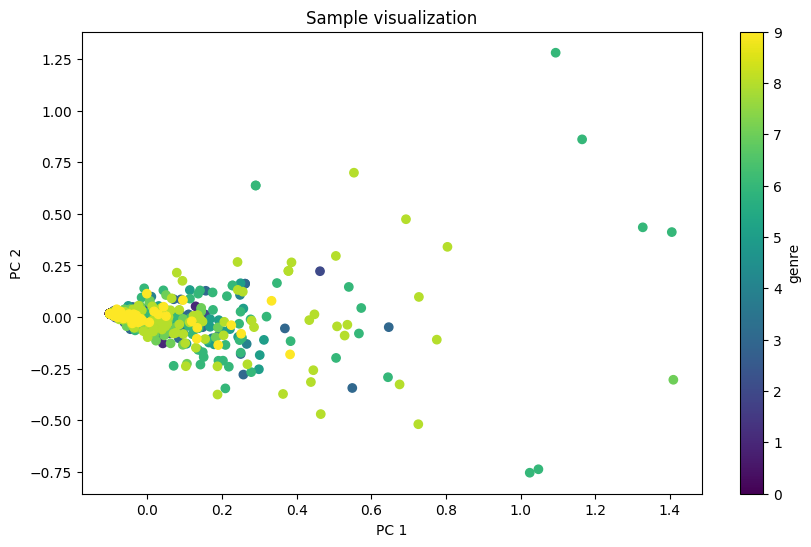


Note that 0-9 on genre color bar start w/classical = 0 & end w/country = 9


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.colorbar(ticks=np.arange(10), label='genre')
plt.title('Sample visualization')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()
print("\nNote that 0-9 on genre color bar start w/classical = 0 & end w/country = 9") #use something besides colorbar


### Question 7
Perform a train-test split and run a logistic regression. Do a simple cross-validation on 1 hyperparameter. How does the train/test performance indicate ?

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression

X_1 = X.reshape(X.shape[0], -1)
X_train, X_test, y_train, y_test = train_test_split(X_1, y)
log = LogisticRegression()
log.fit(X_train.reshape(X_train.shape[0], -1), y_train)

train_acc = log.score(X_train.reshape(X_train.shape[0], -1), y_train)
test_acc = log.score(X_test.reshape(X_test.shape[0], -1), y_test)
cv_acc = cross_val_score(log, X.reshape(X.shape[0], -1), y).mean()

print("Test acc: " + str(round(test_acc,3)))
print("Train acc: " + str(round(train_acc,3)))
print("CV acc: ", round(cv_acc, 3))


Test acc: 0.216
Train acc: 0.331
CV acc:  0.204


The train/test performance indicates low accuracy scores for both and the CV score being low as well means the split isn't necessarily the only reason why. Train accuracy was the highest so overfit to train data could be occuring.

### Question 8
Same question with an SVM classifier. Do two separate gridsearches over 'C' each with a fixed kernel ('linear' and 'rbf). How does the choice of the kernel impact the performance ? Was it expected ?

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [1, 10, 100, 1000]}

svm_linear = SVC(kernel='linear')
svm_rbf = SVC(kernel='rbf')

gs_linear = GridSearchCV(svm_linear, param_grid)
gs_linear.fit(X_train.reshape(X_train.shape[0], -1), y_train)
linear_acc = gs_linear.score(X_test.reshape(X_test.shape[0], -1), y_test)

gs_rbf = GridSearchCV(svm_rbf, param_grid)
gs_rbf.fit(X_train.reshape(X_train.shape[0], -1), y_train)
rbf_acc = gs_rbf.score(X_test.reshape(X_test.shape[0], -1), y_test)

print("Linear Kernel Test Acc:", linear_acc)
print("RBF Kernel Test Accuracy:", rbf_acc)

Linear Kernel Test Acc: 0.296
RBF Kernel Test Accuracy: 0.32


The choice of the kernel did not impact the performance as the RBF kernel performed the same as the Linear kernel. I did not expect that as I assumed one would perform better but the labels/spectrogram features have a linear relationship so that would make sense.

We change the format of the data to torch tensors and perform a train test split.

### Part 3: introduction to deep learning


With pytorch, a neural netwrok is an boject that inherist from `nn.Module`. It must contain:

- a constructor ```___init___``` which specifies its attributes (number of layers, neurones etc)
- a forward function ```forward``` that computes the output of the neural net given a data input `X`.

In [ ]:
import torch
from torch import nn, optim
from sklearn import preprocessing
from sklearn.metrics import classification_report


class NeuralNet(nn.Module):
    """Simple neural net."""

    def __init__(self):
        super(NeuralNet, self).__init__()
        self.linear_layer = nn.Linear(X.shape[1] * X.shape[2], 10)

    def forward(self, X, **kwargs):
        X = self.linear_layer(X)
        return X


### Question 9
What model does this first neural net above correspond to ?


After creating our neural network, we need to write a function that performs the 'fit' operation i.e solve the optimization problem.

The first neural net above corresponds to a linear model as it's initialized with a single linear layer that transforms X data to a vector. (feedfoward)

In [ ]:
def fit_neural_net(neural_net,
                   X_train, X_test, y_train, y_test,
                   learning_rate=0.05,
                   weight_decay=0.,
                   max_iter=1000,
                   device='cpu',
                   verbose=True):
    """
    Function that performs back-propagation (gradient descent)
    to optimize the neural net.
    neural_net: Instance of NeuralNet
    learning_rate: gradient step size
    weight_decay: regularization parameter of L2 regularization
    max_iter: nombre maximum d'itérations
    device: 'cpu' or 'cuda:0'

    Returns
    scores: dictionary of s
    """

    loss_func = nn.CrossEntropyLoss().to(device)
    neural_net = neural_net.to(device)
    optimizer = optim.Adam(neural_net.parameters(), lr=learning_rate, weight_decay=weight_decay)

    loss_train, loss_test = [], []
    accuracy_train, accuracy_test = [], []
    X_train = X_train.to(device)
    X_test = X_test.to(device)
    y_train = y_train.to(device)
    y_test = y_test.to(device)
    if verbose:
        strings = [s.center(15) for s in ["Iteration", "Accuracy Train", "Accuracy Test", "Loss Train", "Loss Test"]]
        strings = [s.center(15) for s in strings]
        strings = " | ".join(strings)
        print(strings)

    for ii in range(max_iter):
        # Train
        neural_net.train()
        optimizer.zero_grad()
        train_output = neural_net(X_train)
        loss_train_ = loss_func(train_output, y_train)  #### compute the loss
        loss_train_.backward()  ### compute the gradients and do back propagation
        optimizer.step()    # gradient step


      # Test
      # turn neural net to evaluation mode to not keep computing gradients
        neural_net.eval()
        with torch.no_grad():
            _, y_pred_train = torch.max(train_output.data, 1)
            test_output = neural_net(X_test.to(device))
            _, y_pred_test = torch.max(test_output.data, 1)
            loss_test_ = loss_func(test_output, y_test).cpu().item()
            accuracy_test_ = (y_pred_test == y_test).float().mean().cpu().item()
            accuracy_train_ = (y_pred_train == y_train).float().mean().cpu().item()

        if verbose and ii % 100 == 0:
            strings = [ii, accuracy_train_, accuracy_test_, loss_train_.item(), loss_test_] # print stuff
            strings = ["{:.4f}".format(s).center(15) for s in strings]
            strings = " | ".join(strings)
            print(strings)

        loss_train.append(loss_train_.cpu().item())
        loss_test.append(loss_test_)
        accuracy_train.append(accuracy_train_)
        accuracy_test.append(accuracy_test_)

    metrics = [[loss_train, loss_test],
              [accuracy_train, accuracy_test]]
    return metrics


def make_report(neural_net, X_test, device="cpu"):
    neural_net.eval()
    y_pred = neural_net(X_test.to(device)).detach().cpu().numpy().argmax(1)
    print(classification_report(y_test.cpu().numpy(), y_pred))


### Question 10
First we need to turn our data to torch tensors. Make sure your data is reshaped properly (i.e of shape (n_samples, n_features)) and not in images shapes (n_samples, width, height).  

On torch, we can move data and objects from CPU to GPU using the `to` command. Depending on how many GPUs you have, you can switch an array X to GPU number 0 by:


In [ ]:
A = torch.ones(1)
A = A.to("cuda:0")
A.device

device(type='cuda', index=0)

and back to cpu:

In [ ]:
A = torch.ones(1)
A = A.to("cuda:0")
A.device

device(type='cuda', index=0)


In this lab, these device switches are done within the train function which accepts an argument `device`. Train the model on cpu and generate a classification report. How did it perform ?


The function `fit_neural_net` outputs metrics (loss, accuracy) for both train and test. You can use its output in the cell below. What do you conclude ?

   Iteration    |  Accuracy Train |  Accuracy Test  |    Loss Train   |    Loss Test   
     0.0000     |      0.1573     |      0.2160     |      2.3024     |      2.2549    
    100.0000    |      0.7973     |      0.3480     |      0.9151     |      2.1225    
    200.0000    |      0.8693     |      0.3520     |      0.6213     |      2.4544    
    300.0000    |      0.9013     |      0.3400     |      0.4772     |      2.7923    
    400.0000    |      0.9253     |      0.3440     |      0.3913     |      3.1060    
    500.0000    |      0.9333     |      0.3400     |      0.3339     |      3.3921    
    600.0000    |      0.9387     |      0.3320     |      0.2928     |      3.6534    
    700.0000    |      0.9413     |      0.3280     |      0.2618     |      3.8946    
    800.0000    |      0.9480     |      0.3240     |      0.2374     |      4.1213    
    900.0000    |      0.9507     |      0.3200     |      0.2176     |      4.3363    
              precision    recal

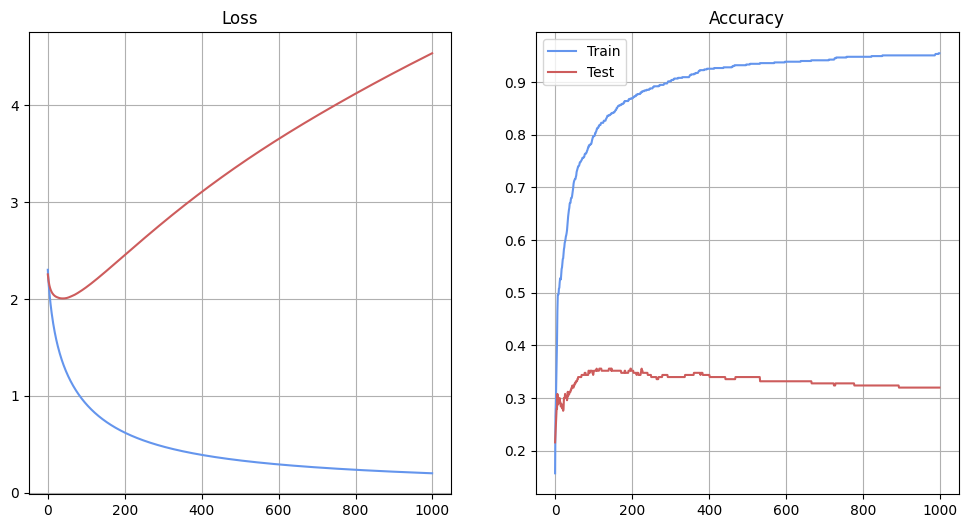

In [ ]:
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

model = NeuralNet()
scores = fit_neural_net(model, X_train, X_test, y_train, y_test)
make_report(model, X_test)
#^use cpu by default

f, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax, metric, metric_name in zip(axes, scores, ['Loss', 'Accuracy']):
    for curve, color, data_type in zip(metric, ['cornflowerblue', 'indianred'], ['Train', 'Test']):
        ax.plot(curve, color=color, label=data_type)
        ax.set_title(metric_name)
        ax.grid(True)
plt.legend()
plt.show()

The test performed substantialy worse than the train over almost all iterations, appears to be an overfit. I can conclude that the model cannot generalize properly at the moment perhaps due to adapting too heavily to the training data.

### Question 11


We add a first hidden layer with 100 neurones and a non-linearity (ReLU activation function). What's the consequence of this decision ? Increase the number of neurones of the hidden layer. Does it impact the result ?

In [ ]:

class NeuralNetHidden(nn.Module):
    def __init__(self):
        super(NeuralNetHidden, self).__init__()
        self.linear_layer = nn.Linear(5632, 100) #changed
        self.hidden_layer = nn.Linear(100, 10)#increase here

    def forward(self, X, **kwargs):
        X = self.linear_layer(X)
        X = torch.relu(X)
        X = self.hidden_layer(X)
        return X


Reducing overffiting with neural nets is not an easy task. But there are several ways to do it:
- Add regularization on the neural weights:
L2 regularization can be controlled by the `weight_decay` parameter of `fit_neural_net`.
- Add more data (bonus). Which can be done using data augmentation techniques i.e transforming the samples you already have to add more samples. Transformation should however be carefully chosen depending on the task.
- Add Dropout layers: dropout cancels some neurones (randomly) to reduce the complexity of the model.
- Add batch normalization layers.
- Reduce the overall depth and complexity of the neural net.



torch.Size([750, 5632]) torch.Size([250, 5632]) torch.Size([750]) torch.Size([250])
   Iteration    |  Accuracy Train |  Accuracy Test  |    Loss Train   |    Loss Test   
     0.0000     |      0.0000     |      0.1040     |      6.2379     |      5.4771    
    100.0000    |      0.9427     |      0.3240     |      0.2268     |      4.7947    
    200.0000    |      0.9813     |      0.2920     |      0.0935     |      7.6092    
    300.0000    |      0.9853     |      0.2960     |      0.0620     |      9.7582    
    400.0000    |      0.9907     |      0.3120     |      0.0473     |     11.6495    
    500.0000    |      0.9920     |      0.3120     |      0.0384     |     13.2634    
    600.0000    |      0.9920     |      0.3040     |      0.0326     |     14.7430    
    700.0000    |      0.9920     |      0.2880     |      0.0284     |     16.1301    
    800.0000    |      0.9920     |      0.2840     |      0.0252     |     17.3748    
    900.0000    |      0.9920     | 

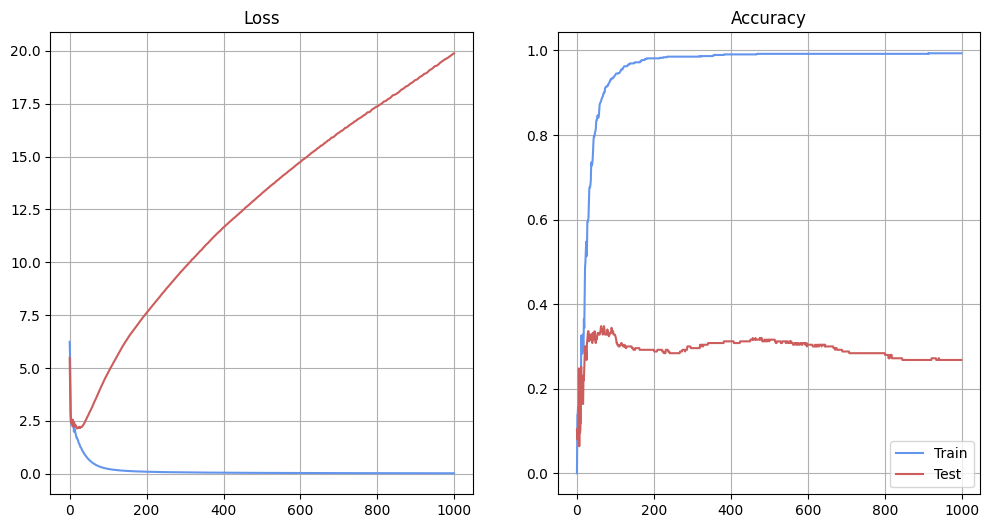

In [ ]:
# X_train = X_train.reshape(-1, 128 * 44)
# X_test = X_test.reshape(-1, 128 * 44)
# X_train = X_train.reshape(X_train.shape[0], -1)

X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

model = NeuralNetHidden()
scores = fit_neural_net(model, X_train, X_test, y_train, y_test)
make_report(model, X_test)
#^use cpu by default

f, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax, metric, metric_name in zip(axes, scores, ['Loss', 'Accuracy']):
    for curve, color, data_type in zip(metric, ['cornflowerblue', 'indianred'], ['Train', 'Test']):
        ax.plot(curve, color=color, label=data_type)
        ax.set_title(metric_name)
        ax.grid(True)
plt.legend()
plt.show()

I edited the requirements of the hidden neural net. Assuming that the compilation is successful, the consequence of this decision would be that the model increases its capacity (meaning more parameters to represent the data), and would contribute to the overfitting problem more with the data we have at the same time. I think the affected result would be higher train and lower test accuracy.

### Part 4 (Bonus): Convolutional neural networks

In [ ]:
class ConvNet(nn.Module):
    """Basic ConvNet"""

    def __init__(self, n_outputs=10, debug=False):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.fc1 = nn.Linear(4320, 100) #changed
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)

        self.fc2 = nn.Linear(100, n_outputs)
        self.maxpool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


A convolution neural net (CNN) is a special design of a neural network for computer vision applications. Since our spectrograms can be seen as images, it is not a bad idea to use a CNN for music genre classification.

First we need to reshape images to have a number of "channels". Here we have only 1 channel (no colors):

In [ ]:
X_train = X_train.reshape(len(X_train), 1, *X[0].shape)
X_test = X_test.reshape(len(X_test), 1, *X[0].shape)

print(X_train.shape, X_test.shape)

torch.Size([750, 1, 128, 44]) torch.Size([250, 1, 128, 44])


Train this conv net and investigate its performance and complexity. Can you beat simple non-deep models ?

In [ ]:
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

device = "cpu"
model = ConvNet()
model = model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

count = 0
for epoch in range(10): #iterations
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train.to(device))
    loss = loss_func(outputs, y_train.to(device))
    loss.backward()
    optimizer.step()
    print(f"Iteration: {count} Loss: {loss.item()}")
    count +=1

make_report(model, X_test, device=device)

<ipython-input-66-eba9b694f4c1>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train)
<ipython-input-66-eba9b694f4c1>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test)
<ipython-input-66-eba9b694f4c1>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train)
<ipython-input-66-eba9b694f4c1>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torc

Iteration: 0 Loss: 2.4318878650665283
Iteration: 1 Loss: 2.2546679973602295
Iteration: 2 Loss: 2.1673314571380615
Iteration: 3 Loss: 2.0929081439971924
Iteration: 4 Loss: 2.0467891693115234
Iteration: 5 Loss: 2.015277147293091
Iteration: 6 Loss: 1.9656803607940674
Iteration: 7 Loss: 1.9392718076705933
Iteration: 8 Loss: 1.9058860540390015
Iteration: 9 Loss: 1.8685405254364014
              precision    recall  f1-score   support

           0       0.09      1.00      0.16        22
           1       0.00      0.00      0.00        23
           2       0.00      0.00      0.00        24
           3       0.00      0.00      0.00        27
           4       0.00      0.00      0.00        20
           5       0.00      0.00      0.00        27
           6       0.00      0.00      0.00        30
           7       0.00      0.00      0.00        23
           8       0.00      0.00      0.00        29
           9       0.00      0.00      0.00        25

    accuracy             

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As the output stands it has not beaten the non-deep models.